In [1]:
import numpy as np 
import os
import sys
import xarray as xr
import scipy.io as sio
import matplotlib.pyplot as plt
import datetime

from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
src_dir = os.environ.get('srcdir')
sys.path.append(src_dir)

# always reload modules marked with "%aimport"
%load_ext autoreload
%autoreload 1


from features.resample_roms import resample
from features.bathy_smoothing import smoothing_PlusMinus_rx0
from features.cartesian_grid_2d import haversine

In [2]:
#run = os.environ.get('run')
run ='waom10'
mr = 1 #km
smooth = True
deepen = True

In [3]:
#establish the grid with grid point distances of mr/2 in km
#we need double resolution to cover all of the staggered grid points (we subset to rho, psi, u, v points later)
#we need an extra line of u and v points at first to calculate all dx and dy on rho points

x,y = np.meshgrid(np.arange(-4300,4300+mr/2,mr/2),np.arange(-3700,3600+mr/2,mr/2))

In [4]:
#load south polar stereographic projection to convert from grid point distance in m to lat/lon and back
from mpl_toolkits.basemap import Basemap
m = Basemap(projection='spstere',lon_0=0,boundinglat=-50,lat_ts=-71)

#get lat/lon coordinates at all grid points by shifting the grid to the lower left corner of the map
lon,lat=m(x*1000+m.urcrnrx/2,y*1000+m.urcrnry/2,inverse=True)

#calculate curvilinear coordinate distances at rho points
dx = haversine(lon[1::2,0:-2:2],lat[1::2,0:-2:2],lon[1::2,2::2],lat[1::2,2::2])
dy = haversine(lon[0:-2:2,1::2],lat[0:-2:2,1::2],lon[2::2,1::2],lat[2::2,1::2])

#calculate curvilinear coordinate metrices
pm = 1.0/dx
pn = 1.0/dy
 
dndx = np.empty_like(pm)
dmde = np.empty_like(pn)

dndx[:,1:-1] = 0.5*(pn[:,2:] - pn[:,:-2])
dmde[1:-1,:] = 0.5*(pm[2:,:] - pm[:-2,:])

dndx[:,0]  = 2*dndx[:,1]  - dndx[:,2]
dndx[:,-1] = 2*dndx[:,-2] - dndx[:,-3]
dmde[0,:]  = 2*dmde[1,:]  - dmde[2,:]
dmde[-1,:] = 2*dmde[-2,:] - dmde[-3,:]

#subset lat and lon at rho, psi, u and v points
lon_rho = lon[1::2,1::2]
lat_rho = lat[1::2,1::2]

lon_psi = lon[2:-1:2,2:-1:2]
lat_psi = lat[2:-1:2,2:-1:2]

lon_u = lon[1::2,2:-1:2]
lat_u = lat[1::2,2:-1:2]

lon_v = lon[2:-1:2,1::2]
lat_v = lat[2:-1:2,1::2]

In [95]:
#load rtopo bed and ice topography and resample to rho points
rtopo_path = os.path.join(os.environ.get('extdir'),'rtopo','RTopo-2.0.1_30sec_*_S30.nc')
rtopo = xr.open_mfdataset(rtopo_path,data_vars='minimal')#.sel(latdim=np.arange(0,7501,50),londim=np.arange(0,43201,100))

rt_lon,rt_lat = np.meshgrid(rtopo.lon.values,rtopo.lat.values)
bed = resample(rt_lon,rt_lat,lon_rho,lat_rho,rtopo.bedrock_topography.values)
ice = resample(rt_lon,rt_lat,lon_rho,lat_rho,rtopo.ice_base_topography.values)

#make a copy of the raw bathymetry
bed_raw = bed.copy()

<IPython.core.display.Javascript object>


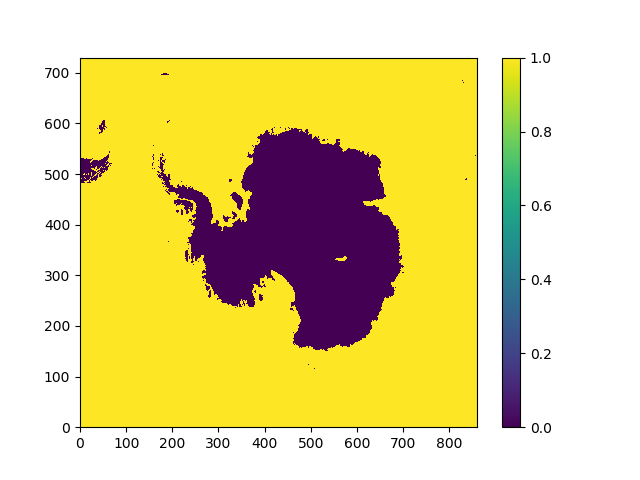

In [105]:
#generate a land/ocean mask depending on water column thickness
#(distance between ice and bed or sea surface and bed)
wct = (-(bed-ice)).copy()
mask = np.ones_like(wct)
mask[wct<20] = 0

In [108]:
smooth = False
#if smoothing is activated smooth the bed and update the mask
if smooth:
    dA = 1.0/(pn*pm) 
    bed_smooth, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(mask,bed,1.0,dA)
    wct_smooth = (-(bed_smooth-ice)).copy()
    mask[wct_smooth<20] = 0
    wct = wct_smooth.copy()
    bed = bed_smooth.copy()

#if deepening is activated, deepen the bed to a minimum water column thickness of 50m 
if deepen:
    shallow = (wct<50)&(wct>=20)
    bed[shallow] = ice[shallow]-50.0

In [125]:
#set spherical flag to 1, since we're creating a curvilinear spherical grid
spherical_da = xr.DataArray(int(1),name='spherical',attrs={'flag_meanings': 'Cartesian spherical',
 'flag_values': np.array([0, 1], dtype=int),
 'long_name': 'grid type logical switch'})

In [126]:
xl = mr*np.size(lat_rho,1)*1000
xl_da = xr.DataArray(xl,name='xl',attrs={'long_name': 'basin length in the XI-direction', 'units': 'meter'} )
el = mr*np.size(lon_rho,0)*1000
el_da = xr.DataArray(el,name='el',attrs={'long_name': 'basin length in the ETA-direction', 'units': 'meter'} )

In [127]:
angle = lon_rho/180.0*np.pi
angle_da = xr.DataArray(angle,name='angle',dims=['eta_rho','xi_rho'],attrs={'long_name': 'angle between XI-axis and EAST', 'units': 'radians'})

In [128]:
pn_da = xr.DataArray(pn,name="pn",dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in ETA', 'units': 'meter-1'})
pm_da = xr.DataArray(pm,name='pm',dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in XI', 'units': 'meter-1'})

In [129]:
dmde_da = xr.DataArray(dmde,name='dmde',dims=['eta_rho','xi_rho'],attrs={'long_name': 'ETA-derivative of inverse metric factor pm', 'units': 'meter'})
dndx_da = xr.DataArray(dndx,name='dndx',dims=['eta_rho','xi_rho'],attrs={'long_name': 'XI-derivative of inverse metric factor nm', 'units': 'meter'})

In [130]:
f = 2*7.29e-5*np.sin(lat_rho*np.pi/180)
f_da = xr.DataArray(f,name='f',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Coriolis parameter at RHO-points', 'units': 'second-1'})

In [132]:
h_da = xr.DataArray(-bed,name='h',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model bathymetry at RHO-points', 'units': 'meter'})
hraw_da = xr.DataArray(-bed_raw,name='hraw',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Working bathymetry at RHO-points', 'units': 'meter'})

In [133]:
zice_da = xr.DataArray(ice,name='zice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model ice draft at RHO-points', 'units': 'meter'})

In [134]:
lon_rho_da = xr.DataArray(lon_rho,name='lon_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'longitude of RHO-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_rho_da = xr.DataArray(lat_rho,name='lat_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'latitude of RHO-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_psi_da = xr.DataArray(lon_psi,name='lon_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'longitude of psi-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_psi_da = xr.DataArray(lat_psi,name='lat_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'latitude of psi-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_u_da = xr.DataArray(lon_u,name='lon_u',dims=['eta_u','xi_u'],attrs={'long_name': 'longitude of u-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_u_da = xr.DataArray(lat_u,name='lat_u',dims=['eta_u','xi_u'],attrs={'long_name': 'latitude of u-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_v_da = xr.DataArray(lon_v,name='lon_v',dims=['eta_v','xi_v'],attrs={'long_name': 'longitude of v-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_v_da = xr.DataArray(lat_v,name='lat_v',dims=['eta_v','xi_v'],attrs={'long_name': 'latitude of v-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})

In [135]:
from features.mask_roms_uvp import uvp_masks

mask_rho = mask.copy()
mask_u,mask_v,mask_psi = uvp_masks(mask_rho)

mask_rho_da = xr.DataArray(mask_rho,name='mask_rho',dims=['eta_rho','xi_rho'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on RHO-points'})
mask_psi_da = xr.DataArray(mask_psi,name='mask_psi',dims=['eta_psi','xi_psi'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on psi-points'})
mask_u_da = xr.DataArray(mask_u,name='mask_u',dims=['eta_u','xi_u'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on u-points'})
mask_v_da = xr.DataArray(mask_v,name='mask_v',dims=['eta_v','xi_v'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on v-points'})

In [136]:
grd = xr.Dataset({'spherical':spherical_da,
                'xl':xl_da,
                'el':el_da,
                'angle':angle_da,
                'pm':pn_da,
                'pn':pn_da,
                'dndx':dndx_da,
                'dmde':dmde_da,
                'f':f_da,
                'h':h_da,
                'hraw':hraw_da,
                'zice':zice_da,
                'lon_rho':lon_rho_da,
                'lat_rho':lat_rho_da,
                'lon_psi':lon_psi_da,
                'lat_psi':lat_psi_da,
                'lon_u':lon_u_da,
                'lat_u':lat_u_da,
                'lon_v':lon_v_da,
                'lat_v':lat_v_da,
                'mask_rho':mask_rho_da,
                'mask_psi':mask_psi_da,
                'mask_u':mask_u_da,
                'mask_v':mask_v_da,},
               attrs={'history': 'GRID file using make_grid.py, smoothing='+str(smooth)+
                      ', deepening='+str(deepen)+', '+str(datetime.date.today()),
                      'type': 'ROMS grid file'})

In [138]:
out_path = os.path.join(os.environ.get('intdir'),'waom'+str(mr)+'_grd.nc')
grd.to_netcdf(out_path,unlimited_dims='bath')